# Development script for Lambert problem solver

Formulation follows Curtis Chapter 5.3 Lambert's Problem pg.247-

Python implementation by Yuri Shimane

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# initial and final position vectors [km]
r_in = np.array([5000, 10000, 2100])
r_fn = np.array([-14600, 2500, 7000])

# time of flight [s]
dt = 3600

# gravitational parameter [km^3/s^2]
mu_E = 398600

# solve Lambert problem
#v1, v2 = lb.lambert(r1=r_in, r2=r_fn, tof=dt, mu=mu_E, grade='pro')
# obtain orbital elements
#elements = oc.sv2el(r_in,v1,mu_E)


In [2]:
from numpy import linalg as LA  # linear algebra functions in numpy

# define functions that will be used repeatedly in iterative solving step
def _Stumpff_S(z):
    """
    Stumpff function S(z)
    Args:
        z (float): universal anomaly^2/semi-major axis of transfer trajectory
    Returns:
        (float): value of Stumpff functio S(z) evaluated for input z
    """
    if z > 0:
        S = (np.sqrt(z) - np.sin(np.sqrt(z)))/np.power(z,1.5)
    elif z == 0:
        S = 1/6
    elif z < 0:
        S = (np.sinh(np.sqrt(-z)) - np.sqrt(-z))/np.power(-z,1.5)

    return S


def _Stumpff_C(z):
    """
    Stumpff function C(z)
    Args:
        z (float): universal anomaly^2/semi-major axis of transfer trajectory
    Returns:
        (float): value of Stumpff functio S(z) evaluated for input z
    """
    if z > 0:
        C = (1 - np.cos(np.sqrt(z)))/z
    elif z == 0:
        C = 1/2
    elif z < 0:
        C = (np.cosh(np.sqrt(-z)) - 1)/(-z)

    return C

def _y_538(r1,r2,A,z):
    """
    Intermediate function in Lambert problem derivation (eq.5.38 in Curtis)
    Args:
        r1 (1x3 numpy array): position vector of departure
        r2 (1x3 numpy array): position vector of arrival
        A (float): intermediate value related only to input parameters
        z (float): universal anomaly^2/semi-major axis of transfer trajectory
    Returns:
        (float): value of function evaluated for input z
    """

    y = LA.norm(r1) + LA.norm(r2) + A*(z*_Stumpff_S(z) - 1)/np.sqrt(_Stumpff_C(z))

    return y

In [15]:
# Lambert solver
def lambert(r1,r2,tof,mu,grade='pro',debugflag=False):
    """
    Function takes in classic parameters to Lambert problem to determine orbitalelements
    Args:
        r1 (1x3 numpy array): initial position vector of departure [km]
        r2 (1x3 numpy array): final position vector of arrival [km]
        tof (float): time of flight [s]
        mu (float): gravitational parameter [km^3/s^2]
        grade (str): trajectory orientation ('pro' for prograde or 'retro' for retrograde)
        debugflag (bool): if set to True, print-out function outputs
    Returns:
        (tuple): velocity vector at position 1 and 2 of solution trajectory to Lambert problem
    """

    # compute dtheta [rad]
    tmp = np.cross(r1,r2)
    # retrgrade orbit
    if grade=='retro':
        if tmp[1] < 0:
            dtheta = np.arccos(np.dot(r1,r2)/(LA.norm(r1)*LA.norm(r2)))
        else: 
            dtheta = 2*np.pi - np.arccos(np.dot(r1,r2)/(LA.norm(r1)*LA.norm(r2)))
    # prograde orbit
    else:
        if tmp[1] < 0:
            dtheta = 2*np.pi - np.arccos(np.dot(r1,r2)/(LA.norm(r1)*LA.norm(r2)))
        else:
            dtheta = np.arccos(np.dot(r1,r2)/(LA.norm(r1)*LA.norm(r2)))
    
    print('dtheta: {}'.format(dtheta*360/(2*np.pi)))

    # compute input parameter A where A = sin(dtheta) * sqrt[r1*r2 / (1 - cos(dtheta))]
    A = np.sin(dtheta) * np.sqrt(LA.norm(r1)*LA.norm(r2)/(1 - np.cos(dtheta)))

    # Newton's method to find z
    z = -60                     # NEEDS TWEAKING
    # compute value of F at initial guess of z
    F = np.power(_y_538(r1,r2,A,z)/_Stumpff_C(z), 3/2) * _Stumpff_S(z) + A*np.sqrt(_y_538(r1,r2,A,z)) - np.sqrt(mu)*tof
    
    if debugflag==True:
        # visualize F(z)
        zplot = np.linspace(z,-z,100)
        Fplot = np.zeros(len(zplot))
        for i in range(len(zplot)):
            Fplot[i] = np.power(_y_538(r1,r2,A,zplot[i])/_Stumpff_C(zplot[i]), 3/2) * _Stumpff_S(zplot[i]) + A*np.sqrt(_y_538(r1,r2,A,zplot[i])) - np.sqrt(mu)*tof
        # show plot F vs. z
        fig, ax = plt.subplots()
        ax.plot(zplot, Fplot)
        ax.grid()
        ax.set_ylim([-100,100])
        plt.show()
        print(f'Values of F for z ranging between -{z} and {z} : \n{Fplot}')
        
    # iterate to find approximate value of z where sign of F turns from positive to negative
    if F < 0:   # ensure that initial guess of z is not positive
        while F < 0:
            z = z + 0.1
            # update value of F
            F = np.power(_y_538(r1,r2,A,z)/_Stumpff_C(z), 3/2) * _Stumpff_S(z) + A*np.sqrt(_y_538(r1,r2,A,z)) - np.sqrt(mu)*tof
    else: # if F > 0:
        while F > 0:
            z = z - 0.1
            # update value of F
            F = np.power(_y_538(r1,r2,A,z)/_Stumpff_C(z), 3/2) * _Stumpff_S(z) + A*np.sqrt(_y_538(r1,r2,A,z)) - np.sqrt(mu)*tof
    
    if debugflag==True:
        print(f'Computed initial guess of z : {z}')
    
    eps = 0.00001          # define error value for Newton's method
    diff = eps * 100       # initial off-set from x-intercept
    count = 1
    
    # define functions for symbolic solver to feed into newton-raphson method
    while diff > eps:
        if debugflag==True:
            print('current iteration: {}'.format(count))
            
        # define functions to solve by Newton's method
        F = np.power(_y_538(r1,r2,A,z)/_Stumpff_C(z), 3/2) * _Stumpff_S(z) + A*np.sqrt(_y_538(r1,r2,A,z)) - np.sqrt(mu)*tof
        
        if z == 0:
            Fdot = np.sqrt(2) * np.power(_y_538(r1,r2,A,0),1.5)/40 + (A/8)*(np.sqrt(_y_538(r1,r2,A,0)) + A*np.sqrt(1/(2*_y_538(r1,r2,A,0))))
        else:
            Fdot = np.power(_y_538(r1,r2,A,z)/_Stumpff_C(z), 1.5) * (((1/(2*z)) * (_Stumpff_C(z) - 3*_Stumpff_S(z)/(2*_Stumpff_C(z)))) + 3*np.power(_Stumpff_S(z),2)/(4*_Stumpff_C(z))) + (A/8)*(3*_Stumpff_S(z)*np.sqrt(_y_538(r1,r2,A,z))/_Stumpff_C(z) + A*np.sqrt(_Stumpff_C(z)/_y_538(r1,r2,A,z)))

        # iterate for next term
        z1 = z - F/Fdot
        if debugflag==True:
            print('current z: {}'.format(z1))

        # update difference term
        diff = np.abs(z - z1)

        # update current guess
        z = z1

        # update current iteration number
        count += 1

        #FIXME: include escape clause
        if count > 1000:
            print('Newton\'s method exceeded {} steps; consider changing initial guess of z for better result'.format(count))
            break


    # display orbit type
    if z > 0:
        print('Transfer trajectory is an ellipse; z = {}'.format(z))
    elif z == 0:
        print('Transfer trajectory is a parabola; z = {}'.format(z))
    elif z < 0:
        print('Transfer trajectory is a hyperbolla; z = {}'.format(z))

    # calculate Lagrange functions
    f    = 1 - _y_538(r1,r2,A,z)/LA.norm(r1)
    g    = A*np.sqrt(_y_538(r1,r2,A,z)/mu)
    gdot = 1 - _y_538(r1,r2,A,z)/LA.norm(r2)
    if debugflag==True:
        print(f'Lagrange functions f: {f}, g: {g}, gdot: {gdot}')

    # calculate initial and final velocity vectors
    v1 = (1/g)*(r2 - f*r1)
    v2 = (1/g)*(gdot*r2 - r1)
    print('Velocity at r1: {}, velocity at r2: {}'.format(v1,v2))

    return v1, v2


dtheta: 259.70747579270375


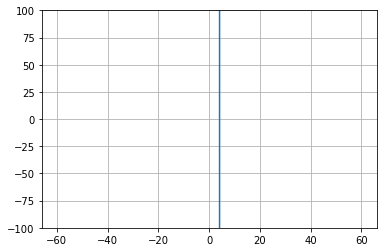

Values of F for z ranging between --60 and -60 : 
[-1.77026138e+06 -1.76094239e+06 -1.75136503e+06 -1.74151874e+06
 -1.73139235e+06 -1.72097404e+06 -1.71025128e+06 -1.69921079e+06
 -1.68783845e+06 -1.67611925e+06 -1.66403723e+06 -1.65157538e+06
 -1.63871554e+06 -1.62543832e+06 -1.61172300e+06 -1.59754737e+06
 -1.58288762e+06 -1.56771817e+06 -1.55201152e+06 -1.53573804e+06
 -1.51886579e+06 -1.50136022e+06 -1.48318395e+06 -1.46429647e+06
 -1.44465374e+06 -1.42420786e+06 -1.40290660e+06 -1.38069288e+06
 -1.35750425e+06 -1.33327215e+06 -1.30792123e+06 -1.28136841e+06
 -1.25352194e+06 -1.22428019e+06 -1.19353034e+06 -1.16114675e+06
 -1.12698918e+06 -1.09090059e+06 -1.05270462e+06 -1.01220260e+06
 -9.69169946e+05 -9.23351959e+05 -8.74458721e+05 -8.22158997e+05
 -7.66072857e+05 -7.05762725e+05 -6.40722444e+05 -5.70363868e+05
 -4.94000305e+05 -4.10825947e+05 -3.19890160e+05 -2.20065106e+05
 -1.10004687e+05  1.19079429e+04  1.47628026e+05  2.99537178e+05
  4.70558893e+05  6.64311745e+05  8.8531

In [16]:
# solve Lambert problem
v1, v2 = lambert(r1=r_in, r2=r_fn, tof=dt, mu=mu_E, grade='pro',debugflag=True)


In [5]:
v1, v2 = lambert(r1=r_in, r2=r_fn, tof=dt, mu=mu_E, grade='retro')

dtheta: 100.29252420729621


C:\Users\yurio\Anaconda3\envs\mcc\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in power
C:\Users\yurio\Anaconda3\envs\mcc\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in sqrt
C:\Users\yurio\Anaconda3\envs\mcc\lib\site-packages\ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in power
C:\Users\yurio\Anaconda3\envs\mcc\lib\site-packages\ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in sqrt
C:\Users\yurio\Anaconda3\envs\mcc\lib\site-packages\ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in power
C:\Users\yurio\Anaconda3\envs\mcc\lib\site-packages\ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in sqrt


UnboundLocalError: local variable 'S' referenced before assignment